In [1]:
import numpy as np
from numpy import linalg
import scipy
from scipy import fftpack
from scipy import optimize
import matplotlib.pyplot as plt
import time
import snap
import prox_tv as ptv


In [13]:
#Stochastic Block Model

G = snap.GenRndGnm(snap.PNEANet, 4000, 0, False)
Interieur = 0.1
Exterieur = 0.005
for v in G.Nodes():
    for w in G.Nodes():
        U = np.random.rand()
        if v.GetId() % 1000 == w.GetId() % 1000:
            if U < Interieur:
                G.AddEdge(v.GetId(),w.GetId())
        else:
            if U < Exterieur:
                G.AddEdge(v.GetId(),w.GetId())

In [31]:
#G = snap.LoadEdgeList(snap.PNEANet, "com-orkut.ungraph.txt", 0, 1)
#G = snap.LoadEdgeList(snap.PNEANet, "facebook_combined.txt", 0, 1)
N = G.GetMxNId()
M = G.GetEdges()
print N,M

4000 81117


In [32]:
#The Snake algorithm

def Rnd_Edge(G):
    e = G.GetRndEId()
    e = G.GetEI(e)
    e = list(np.random.permutation([e.GetSrcNId(),e.GetDstNId()]))
    return e

def Uniform_Neib(k,G):
    v = G.GetNI(k)
    k = v.GetNbrNId(np.random.randint(v.GetDeg()))
    return k

def Simple_Path(e,l,G):
    C = e
    k = Uniform_Neib(e[-1],G)
    while (k not in C) and (len(C) < l-1): #Accelerer?
        C += [k]
        k = Uniform_Neib(k,G)
    return C, [C[-1],k]

def Prox_1D(x, C, alpha, R):
    y = np.copy(x)
    res = y.flat[C]
    if R == 'TV':
        res = ptv.tv1_1d(res, alpha, method = 'tautstring')
    elif R == 'Laplace':
        n = len(C)
        res = scipy.fftpack.dct(res, type=2)
        res = res * [1/(1.0 + 4.0*alpha*float(1 - np.cos((np.pi)*float(j) / float(n)) )) for j in range(n)]
        res = 1/(2*float(n))*scipy.fftpack.dct(res, type=3)
    #elif R = 'w_Laplace':
    #elif R = 'Laplace_n':
    y.flat[C] = res
    return y
    

def Snake(G, x, Grad_F, R = 'TV', sec = 10, cte = 1.0, lgr = G.GetNodes()):
    #res = np.copy(x)
    l = lgr
    e = Rnd_Edge(G)
    n = 1
    gamma_n = cte/float(n)
    debut = time.time()
    
    while time.time() - debut < sec:
        C, e = Simple_Path(e, l, G)
        x = x - gamma_n * (len(C) - 1) * Grad_F(x)
        x = Prox_1D(x, C, G.GetEdges()*gamma_n, R)
        l = l - (len(C) - 1)
        if l == 0:
            l = lgr
            n += 1
            gamma_n = cte/float(n)
            e = Rnd_Edge(G)
          
    return x #, n 


In [33]:
#Mean length of a loop in G

e = Rnd_Edge(G)
moyenne = len(Simple_Path(e,N,G)[0])

for n in xrange(1,1000):
    e = Rnd_Edge(G)
    moyenne = moyenne + 1/float(n+1)*(len(Simple_Path(e,N,G)[0]) - moyenne)
    #print moyenne
    
moyenne

29.000000000000014

In [34]:
#Functions one need to apply the Snake algorithm

#Data fitting term
def Data(x,y):
    return 1/2.0 * np.linalg.norm(x-y)**2

#Gradient of the data fitting term
def Grad_F(x):
    return x - y #coeff

#TV regularization
def TV(x,G):
    r = 0
    for e in G.Edges():
        r += np.abs(x[e.GetSrcNId()] - x[e.GetDstNId()])
    return r

#Estimation of TV with l random edges
def TV_approx(x,G,l):
    r = 0
    for i in range(l):
        e = G.GetRndEId()
        e = G.GetEI(e)
        r += np.abs(x[e.GetSrcNId()] - x[e.GetDstNId()])
    return G.GetEdges()/float(l) * r    

#TV regularized risk
def Obj_TV(x,y,G,lambd = 1.0):
    return lambd * TV(x,G) + Data(x,y)

#Estimation of the TV regularized risk with l random edges
def Obj_TV_approx(x,y,G,l,lambd = 1.0):
    return lambd * TV_approx(x,G,l) + Data(x,y)

#Laplacian regularization
def Laplace(x,G):
    r = 0
    for e in G.Edges():
        r += np.linalg.norm(x[e.GetSrcNId()] - x[e.GetDstNId()])**2
    return r
    
#Estimation of the Laplacian regularization with l random edges
def Laplace_approx(x,G,l):
    r = 0
    for i in range(l):
        e = G.GetRndEId()
        e = G.GetEI(e)
        r += np.linalg.norm(x[e.GetSrcNId()] - x[e.GetDstNId()])**2
    return G.GetEdges()/float(l) * r    

#Laplacian regularized risk
def Obj_Laplace(x,y,G,lambd = 1.0):
    return lambd * Laplace(x,G) + Data(x,y)

#Estimation of the Laplacian regularized risk with l random edges
def Obj_Laplace_approx(x,y,G,l, lambd = 1.0):
    return lambd * Laplace_approx(x,G,l) + Data(x,y)
  
    

In [35]:
#Functions one need to apply the projected gradient algorithm 
#to the dual problem of the TV regularized risk minimization

#Nabla denotes the incidence matrix of G

#Computes the coordinate e of Nabla x
def Nabla_Coord(x,G,e):
    y = np.zeros(G.GetMxEId())
    y[e.GetId()] = x[e.GetSrcNId()] - x[e.GetDstNId()]
    return y


#Computes Nabla x
def Nabla(x,G):
    y = np.zeros(G.GetMxEId())
    for e in G.Edges():
        y[e.GetId()] = x[e.GetSrcNId()] - x[e.GetDstNId()] 
        #e.GetSrcNId() < e.GetDstNId()
    return y

#Computes Nabla.T u
def NablaT(u,G):
    y = np.zeros(G.GetMxNId())
    for v in G.Nodes():
        r = 0
        i = v.GetId()
        for k in range(v.GetDeg()):
            if i < v.GetNbrNId(k):
                e = G.GetEI(i,v.GetNbrNId(k))
                r += u[e.GetId()]
            else:
                e = G.GetEI(v.GetNbrNId(k),i)
                r -= u[e.GetId()]
        y[v.GetId()] = r
    return y


#Objective function of the dual problem of the TV regularized risk minimization
def Objectif_Dual(u,y,G):
    return (1.0/2.0)*(linalg.norm(NablaT(u,G),2))**2 - np.inner(u,Nabla(y,G))

#Gradient of this objective function
def Gradient_Dual(u,y,G):
    return Nabla(NablaT(u,G),G) - Nabla(y,G)    

#Computes the primal variable x from the dual variable u
def Primal(u,y,G):
    return y - NablaT(u,G)

#Dual Gap
def Gap(x, u, G, pas = 1.0):
    b = Nabla(x,G)
    return pas*np.linalg.norm(b, 1) - np.inner(u,b)

#Hard thresholding with threshold = seuil
#This is the projection step in the projected gradient algorithm
def Seuillage_Dur(v,seuil = 1.0):
    y = np.copy(v)
    for i in range(len(v)):
        if np.abs(v[i]) > seuil:
            y[i] = np.sign(v[i])*seuil
    return y    

In [36]:
#Data

#Sample data y
y = np.random.randn(N)
print 1/2.0*np.linalg.norm(y)**2

coeff = 1.0
y = coeff * y


#Regularization parameter for the TV risk minimization
#This choice ensure that the data fitting term and the regularization have the same "weight" 
#at the beginning of the algorithm
lambd = coeff * N * np.sqrt(np.pi) / (2*M)

estim = M/100
print lambd*TV_approx(y,G,estim)/Data(coeff * np.random.randn(N),y) 

1987.74979282
0.964941288712


In [37]:
def NablaT(u,G):
    y = np.zeros(G.GetMxNId())
    for v in G.Nodes():
        r = 0
        i = v.GetId()
        for k in range(v.GetOutDeg()):
            e = G.GetEI(i,v.GetOutNId(k))
            r += u[e.GetId()]
        for k in range(v.GetInDeg()):
            e = G.GetEI(v.GetInNId(k),i)
            r -= u[e.GetId()]
        y[v.GetId()] = r
    return y


# TV risk minimization : ProxTV

In [38]:
#Parameter

#We will run the algorithms during sec seconds
#sec = 25000 #for the Orkut graph
sec = 100 #for the Facebook graph

In [39]:
#Projected gradient algorithm applied to the dual problem

#The dictionnary PG will contain the necessary material for the simulation visualization
PG = {}

#Step-size
#For the Orkut graph
#pas = 0.00005

#For the Facebook graph
pas = 0.001 #0.002 should work

#The first iterate of the algorithm is chosen so that the primal corresponding variable is y
#That is the first iterate is u = 0
u = np.zeros(M)

#PG['TV'] contains the values of the TV norm on the iterates of the algorithm
#Over the Orkut graph, one can approximate the first value of the TV norm by its mean by setting
#PG['TV'] = [2/np.sqrt(np.pi)*G.GetEdges()]
#Over the Facebook graph, this value is quickly computed so one can set directly
PG['TV'] = [TV(y,G)]

#PG['Data'] contains the values of the Data fitting term (of the primal problem) 
#on the iterates of the algorithm. Since we start at y, it starts at zero
PG['Data'] = [0]

#PG['time'] chronometers the running of the algorithm
PG['time'] = [0]

print PG['time'][-1]
while PG['time'][-1] < sec :
    
    temps = time.time()
    u = u - pas * (Nabla(NablaT(u,G),G) - Nabla(y,G))
    u = Seuillage_Dur(u,lambd)
    temps = time.time()-temps
    
    PG['time'] += [PG['time'][-1] + temps]
    #print PG['time'][-1]
    
    x = Primal(u,y,G)
    PG['TV'] += [TV(x,G)]
    PG['Data'] += [Data(x,y)]
    #print PG['Data'][-1] + lambd*PG['TV'][-1]
    
PG['Obj'] = np.asarray(PG['Data']) + lambd*np.asarray(PG['TV'])

0


In [94]:


#Snake for the TV regularized risk minimization
R = 'TV'

#The dictionnary SnakeTV will contain the necessary material for the simulation visualization
#SnakeTV = {}

#The step size is taken to be cte/n
aj = 5.0 #10 works
cte = coeff*G.GetNodes()/aj
ListL = [4000] #We run Snake for L in ListL

tip = time.time()
for i in ListL:
    
    n = 1
    gamma_n = cte /float(n)

    #lgr = L in the paper
    #lgr is taken to be the expected time of return to the starting point of the random walk
    lgr = i #G.GetNodes() #one can take lgr = 100 if one wants smaller iterations
    l = lgr

    #The first iterate of the algorithm is chosen to be y
    x = np.copy(y)

    #SnakeTV[('TV',lgr)] contains the values of the TV norm on the iterates of the algorithm
    #Over the Orkut graph, one can approximate the first value of the TV norm by its mean by setting
    #SnakeTV[('TV',lgr)] = [2/np.sqrt(np.pi)*G.GetEdges()]
    #Over the Facebook graph, this value is quickly computed so one can set directly
    SnakeTV[('TV',lgr)] = [TV(x,G)]

    #SnakeTV[('Data',lgr)] contains the values of the Data fitting term
    #on the iterates of the algorithm. Since we start at y, it starts at zero
    SnakeTV[('Data',lgr)] = [Data(x,y)]

    #SnakeTV[('time',lgr)] chronometers the running of the algorithm
    SnakeTV[('time',lgr)] = [0]

    #Initializing the random walk
    e = Rnd_Edge(G)

    print SnakeTV[('time',lgr)][-1]
    
    compteur = 0
    mod = 20000 / i
    temps = time.time()
    while SnakeTV[('time',lgr)][-1] < sec: 

        C, e = Simple_Path(e, l, G)  
        x = x - gamma_n * (len(C) - 1)/(np.float(lgr) * M) * Grad_F(x)
        x = Prox_1D(x, C, gamma_n/np.float(lgr), R)
        l = l - (len(C) - 1)


        if l == 0:
            l = lgr
            n += 1
            gamma_n = cte /float(n)
            e = Rnd_Edge(G)
            compteur += 1
            
            if compteur % mod == 0: #We mark a point each time the algorithm visited 20000 nodes
                temps = time.time() - temps
                SnakeTV[('time',lgr)] += [SnakeTV[('time',lgr)][-1] + temps]
                SnakeTV[('TV',lgr)] += [TV(x,G)]
                SnakeTV[('Data',lgr)] += [Data(x,y)]
                temps = time.time()

    SnakeTV[('Obj',lgr)] = np.asarray(SnakeTV[('Data',lgr)]) + lambd*np.asarray(SnakeTV[('TV',lgr)])
    
top = time.time()
top - tip

0


291.96807885169983

In [40]:
#L-BFGS-B algorithm applied to the dual problem
#Lead to a memory error over the Orkut graph

#The dictionnary BFGS will contain the necessary material for the simulation visualization
BFGS = {}

#The first iterate of the algorithm is chosen so that the primal corresponding variable is y
#That is the first iterate is u = 0
u = np.zeros(M)

#BFGS['TV'] contains the values of the TV norm on the iterates of the algorithm
#Over the Orkut graph, one can approximate the first value of the TV norm by its mean by setting
#BFGS['TV'] = [2/np.sqrt(np.pi)*G.GetEdges()]
#Over the Facebook graph, this value is quickly computed so one can set directly
BFGS['TV'] = [TV(y,G)]

#BFGS['Data'] contains the values of the Data fitting term (of the primal problem) 
#on the iterates of the algorithm. Since we start at y, it starts at zero
BFGS['Data'] = [0]

#PG['time'] chronometers the running of the algorithm
BFGS['time'] = [0]

#Box constraint
bound = [(-lambd,lambd)]*M

print BFGS['time'][-1]
while BFGS['time'][-1] < sec:
    temps = time.time()
    
    rep = scipy.optimize.fmin_l_bfgs_b(Objectif_Dual, u, fprime = Gradient_Dual, 
    args = (y,G), bounds = bound, maxiter = 2)
    
    temps = time.time()-temps
    
    u = rep[0]
    
    BFGS['time'] += [BFGS['time'][-1] + temps]
    #print BFGS['time'][-1]
    
    x = Primal(u,y,G)
    BFGS['TV'] += [TV(x,G)]
    BFGS['Data'] += [Data(x,y)]
    #print BFGS['Data'][-1] + lambd*BFGS['TV'][-1]
    
BFGS['Obj'] = np.asarray(BFGS['Data']) + lambd*np.asarray(BFGS['TV'])

0


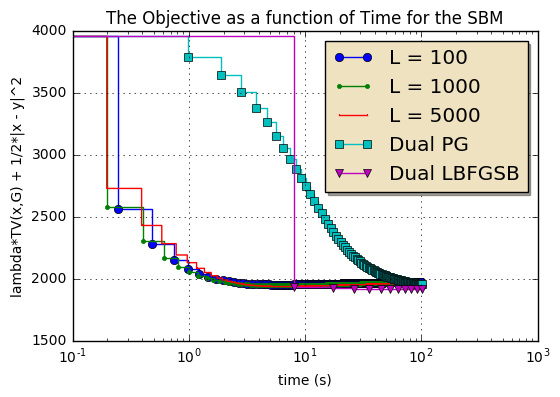

In [107]:
%matplotlib inline

Liste_de_base = [10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]

i = 100
snake = plt.plot(SnakeTV[('time',i)],SnakeTV[('Obj',i)],drawstyle='steps-post',marker = 'o',label = 'L = '+str(i))
i = 1000
snake = plt.plot(SnakeTV[('time',i)],SnakeTV[('Obj',i)],drawstyle='steps-post',marker = '.',label = 'L = '+str(i))
i = 5000
snake = plt.plot(SnakeTV[('time',i)],SnakeTV[('Obj',i)],drawstyle='steps-post',marker = ',',label = 'L = '+str(i))
#i = 4000
#snake = plt.plot(SnakeTV[('time',i)],SnakeTV[('Obj',i)],drawstyle='steps-post',marker = '*',label = 'L = '+str(i))
#for i in [100,1000,5000]:
#snake = plt.plot(SnakeTV[('time',i)],SnakeTV[('Obj',i)],drawstyle='steps-post',marker = 'o',label = 'Snake with L = '+str(i))
pg = plt.plot(PG['time'],PG['Obj'],drawstyle='steps-post',marker = 's',label='Dual PG')
bfgs = plt.plot(BFGS['time'],BFGS['Obj'],drawstyle='steps-post',marker = 'v',label='Dual LBFGSB')
 

plt.xlabel('time (s)')
plt.ylabel('lambda*TV(x,G) + 1/2*|x - y|^2')
plt.title('The Objective as a function of Time for the SBM')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
plt.xscale('log')
plt.grid()
plt.savefig('Review-SBM-TV-L-log.png')
plt.show()


In [77]:
len(SnakeTV[('time',i)])

399

# Laplacian risk minimization : Harmonic energy minimization

In [ ]:
#Data

#Vector of unobserved nodes
vec0 = snap.TIntV() 
for v in G.Nodes():
    k = v.GetId() 
    if k < G.GetNodes()/2:
        vec0.Add(v.GetId())
    
#Vector of observed nodes
vec1 = snap.TIntV()
for v in G.Nodes():
    k = v.GetId() 
    if k >= G.GetNodes()/2:
        vec1.Add(v.GetId())  
    
#Graph of observed nodes    
G1 = snap.GetSubGraph(G, vec1)

#Graph of unobserved nodes
G0 = snap.GetSubGraph(G, vec0)

#External degree in G0 of a node in G1
d1_ext = np.zeros(G.GetMxNId() - G.GetNodes()/2)
for v in G1.Nodes():
    k = v.GetId()
    v0 = G.GetNI(k)
    d1_ext[k - G.GetNodes()/2] = (v0.GetDeg() - v.GetDeg())

#External degree in G1 of a node in G0
d0_ext = np.zeros(G.GetNodes()/2)
for v in G0.Nodes():
    k = v.GetId()
    v1 = G.GetNI(k)
    d0_ext[k] = v1.GetDeg() - v.GetDeg()
    
print G0.GetMxNId(), G1.GetMxNId()

In [ ]:
#Functions one need to apply the conjugate gradient algorithm 

#Computes the Laplacian value at x over G
def L(x,G):
    y = np.zeros(G.GetMxNId()+1)
    for v in G.Nodes():
        i = v.GetId()
        y[i] = v.GetDeg()*x[i] - sum([x[v.GetNbrNId(k)] for k in range(v.GetDeg())])
    return y

#Corresponds to the matrix D_G - A_G0 
def Mat(x,G0,G):
    y = np.zeros(G.GetNodes()/2)
    for v0 in G0.Nodes():
        i = v0.GetId()
        v = G.GetNI(i)
        y[i] = v.GetDeg()*x[i] - sum([x[v0.GetNbrNId(k)] for k in range(v0.GetDeg())]) 
    return y

#This vector will be useful in the sequel
Y = np.zeros(G.GetNodes()/2)
for v0 in G0.Nodes():
    i = v0.GetId()
    v = G.GetNI(i)
    Y[i] = sum([y[v.GetNbrNId(k)] for k in range(v.GetDeg()) if v.GetNbrNId(k) >= G.GetNodes()/2])


In [ ]:
#Parameter

#We will run the algorithms during sec seconds
#sec = 4000 #for the Orkut graph
sec = 1.0 #for the Facebook graph

#x_test = np.asarray([np.mean(x1)]*len(x0))

In [ ]:
#Snake for the Laplacian regularized risk minimization
R = 'Laplace'

#The dictionnary SnakeLaplace will contain the necessary material for the simulation visualization
SnakeLaplace = {}

#The step size is taken to be cte/sqrt(n) over the Orkut graph
#aj = 0.5
#cte = coeff/(aj*float(G.GetEdges()))
#n = 1
#gamma_n = cte /np.sqrt(float(n))

#The step size is taken to be cte/n over the Facebook graph
aj = 1.0
cte = coeff/(aj*float(G.GetEdges()))
n = 1
gamma_n = cte /float(n)


#lgr = L in the paper
lgr = G.GetNodes()/10 #one can take lgr = 100 if one wants smaller iterations
l = lgr

#lgr = G.GetNodes()/50 over the Orkut graph

#The gradient of the data fitting term in x0 is 2 * (x0*d0_ext - Y)

#The first iterate of the algorithm (vector x over G0) is chosen to be 0, 
#The vector of observed nodes is chosen to coincide with y on observed nodes
x0 = np.zeros(G.GetNodes()/2)
x1 = y[G.GetNodes()/2:G.GetMxNId()]



#The corresponding harmonic energy is zero_harmonic_energy
zero_harmonic_energy = Laplace(np.asarray(list(x0)+list(x1)),G)

#One can check that the harmonic energy of a vector x over G can be expressed 
#via its restriction x0 to G0 by the expression 
#zero_harmonic energy - 2*np.inner(x0,Y) + np.inner(x0,Mat(x0,G0,G))



#SnakeLaplace[('harmonic_energy',lgr)] contains the values of the harmonic energy 
#on the iterates of the algorithm. The first value is
SnakeLaplace[('harmonic_energy',lgr)] = [zero_harmonic_energy]

#SnakeLaplace[('time',lgr)] chronometers the running of the algorithm
SnakeLaplace[('time',lgr)] = [0]


#Initializing the random walk
e = Rnd_Edge(G0)

print SnakeLaplace[('time',lgr)][-1]

temps = time.time()
while SnakeLaplace[('time',lgr)][-1] < sec: 
    
    C, e = Simple_Path(e, l, G0)  
    x0 = x0 - gamma_n * (len(C) - 1) * 2 * (x0*d0_ext - Y)
    x0 = Prox_1D(x0, C, G0.GetEdges() * gamma_n, R)
    l = l - (len(C) - 1)
    
    
    if l == 0:
        l = lgr
        n += 1
        gamma_n = cte /np.sqrt(float(n))
        e = Rnd_Edge(G0)
        
        temps = time.time() - temps
        SnakeLaplace[('time',lgr)] += [SnakeLaplace[('time',lgr)][-1] + temps]
        print SnakeLaplace[('time',lgr)][-1]
        
        SnakeLaplace[('harmonic_energy',lgr)] += [zero_harmonic_energy + np.inner(x0,Mat(x0,G0,G) - 2*Y)]
        print SnakeLaplace[('harmonic_energy',lgr)][-1]
        
        temps = time.time()

In [ ]:
#Conjugate gradient for the Laplacian regularized risk minimization

#The dictionnary CG will contain the necessary material for the simulation visualization
CG = {}


#Our problem boils down to solving the linear system associated with the matrix Mat(.,G0,G) and the vector Y

#The first iterate of the algorithm (vector x over G0) is chosen to be 0, 
#The vector of observed nodes is chosen to coincide with y on observed nodes
x0 = np.zeros(G.GetNodes()/2)
x1 = y[G.GetNodes()/2:G.GetMxNId()]

#The corresponding harmonic energy is zero_harmonic_energy
zero_harmonic_energy = Laplace(np.asarray(list(x0)+list(x1)),G)

#One can check that the harmonic energy of a vector x over G can be expressed 
#via its restriction x0 to G0 by the expression 
#zero_harmonic energy - 2*np.inner(x0,Y) + np.inner(x0,Mat(x0,G0,G))


#CG['harmonic_energy'] contains the values of the harmonic energy 
#on the iterates of the algorithm. The first value is
CG['harmonic_energy'] = [zero_harmonic_energy]

#CG['time'] chronometers the running of the algorithm
CG['time'] = [0]


print CG['time'][-1]

#Initializing the conjugate gradient algorithm
tip = time.time()
Mx = np.zeros(G.GetNodes()/2) # = CG(x0,G0,G)
r = Y #- Lx
p = np.copy(r)
top = time.time()

print top - tip

while CG['time'][-1] < sec:
    
    temps = time.time()
    
    Mp = Mat(p,G0,G)
    
    print time.time() - temps
    
    alpha = (np.linalg.norm(r)**2) /(np.inner(p,Mp))
    x0 = x0 + alpha*p
    r1 = np.copy(r)
    r = r - alpha*Mp
    beta = (np.linalg.norm(r)**2)/(np.linalg.norm(r1)**2)
    p = r + beta*p
    Mx = Mx + alpha*Mp
    
    temps = time.time()-temps
    
    
    CG['time'] += [CG['time'][-1] + temps]
    print CG['time'][-1]
    
    CG['harmonic_energy'] += [zero_harmonic_energy + np.inner(x0,Mat(x0,G0,G) - 2*Y)]
    print CG['harmonic_energy'][-1]
    

In [ ]:
%matplotlib inline
snakeL = plt.plot(SnakeLaplace[('time',lgr)],SnakeLaplace[('harmonic_energy',lgr)],drawstyle='steps-post',marker = 'o',label = 'Snake')
cg = plt.plot(CG['time'],CG['harmonic_energy'],drawstyle='steps-post',marker = 's',label='Conjugate Gradient')
 

plt.xlabel('time (s)')
plt.ylabel('x*Lx')
plt.title('The Objective as a function of Time for the Facebook Graph') #Or Orkut Graph
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
#plt.savefig('harmonic-FB.png')
plt.show()


# Laplacian risk minimization : Solving Lx = b

In [ ]:
#Functions one need to apply the conjugate gradient algorithm 

#Computes the Laplacian value at x over G
def L(x,G):
    y = np.zeros(G.GetMxNId())
    for v in G.Nodes():
        i = v.GetId()
        y[i] = v.GetDeg()*x[i] - sum([x[v.GetNbrNId(k)] for k in range(v.GetDeg())])
    return y

b = np.copy(y)

In [ ]:
#Parameter

#We will run the algorithms during sec seconds
sec = 36000 #for the Orkut graph
#sec = ??? #for the Facebook graph
sec = 1

In [ ]:
#Snake for solving Lx = b
R = 'Laplace'

#The dictionnary SnakeLxb will contain the necessary material for the simulation visualization
SnakeLxb = {}


#The step size is taken to be cte/n over the Orkut graph
aj = 4.0
cte = coeff/(aj*float(G.GetEdges()))
n = 1
gamma_n = cte / float(n)


#lgr = L in the paper
lgr = G.GetNodes()
l = lgr

#The first iterate of the algorithm is chosen to be 0 or b
x = np.zeros(N)
#x = np.copy(b)
Lx = L(x,G)


#SnakeLxb[('distance',lgr)] contains the values of the distance |Lx - b| at the iterate x of the algorithm 
SnakeLxb[('distance',lgr)] = [np.linalg.norm(Lx - b)]

#SnakeLxb[('time',lgr)] chronometers the running of the algorithm
SnakeLxb[('time',lgr)] = [0]



#Initializing the random walk
e = Rnd_Edge(G0)

print SnakeLxb[('time',lgr)][-1]

temps = time.time()
while SnakeLxb[('time',lgr)][-1] < sec: 
    
    C, e = Simple_Path(e, l, G)  
    x = x + gamma_n * (len(C) - 1) * b
    x = Prox_1D(x, C, G.GetEdges() * gamma_n, R)
    l = l - (len(C) - 1)
    
    if l == 0:
        l = lgr
        n += 1
        gamma_n = cte /(float(n))
        e = Rnd_Edge(G)
        
        temps = time.time() - temps
        SnakeLxb[('time',lgr)] += [SnakeLxb[('time',lgr)][-1] + temps]
        print SnakeLxb[('time',lgr)][-1]
        
        SnakeLxb[('distance',lgr)] += [np.linalg.norm(L(x,G)-b)]
        print SnakeLxb[('distance',lgr)][-1]
        
        temps = time.time()

In [ ]:
#Conjugate gradient for the resolution of Lx = b

#The dictionnary Lxb will contain the necessary material for the simulation visualization
Lxb = {}

#We want to solve the linear system associated with the matrix L(.,G) and the vector b

#The first iterate of the algorithm is chosen to be 0 or b
x = np.zeros(N)
#x = np.copy(b)
Lx = L(x,G)


#Lxb['distance'] contains the values of the distance |Lx - b| at the iterate x of the algorithm 
Lxb['distance'] = [np.linalg.norm(Lx - b)]

#Lxb['time'] chronometers the running of the algorithm
Lxb['time'] = [0]


print Lxb['time'][-1]

#Initializing the conjugate gradient algorithm
tip = time.time()
r = b - Lx
p = np.copy(r)
top = time.time()

print top - tip


while Lxb['time'][-1] < sec:
    
    temps = time.time()
    
    Lp = L(p,G)
    
    print time.time() - temps
    
    alpha = (np.linalg.norm(r)**2) /(np.inner(p,Lp))
    x = x + alpha*p
    r1 = np.copy(r)
    r = r - alpha*Lp
    beta = (np.linalg.norm(r)**2)/(np.linalg.norm(r1)**2)
    p = r + beta*p
    Lx = Lx + alpha*Lp
    
    temps = time.time()-temps
    
    
    Lxb['time'] += [Lxb['time'][-1] + temps]
    print Lxb['time'][-1]
    
    Lxb['distance'] += [np.linalg.norm(Lx - b)]
    print Lxb['distance'][-1]
    

In [ ]:
print len(Lxb['distance']),len(Lxb['time']),len(SnakeLxb[('distance',lgr)]),len(SnakeLxb[('time',lgr)])


In [ ]:
%matplotlib inline
snakeLxb = plt.plot(SnakeLxb[('time',lgr)],SnakeLxb[('distance',lgr)],drawstyle='steps-post',marker = 'o',label = 'Snake')
cglxb = plt.plot(Lxb['time'],Lxb['distance'],drawstyle='steps-post',marker = 's',label='Conjugate Gradient')
 

plt.xlabel('time (s)')
plt.ylabel('|Lx - b|')
plt.title('The Objective as a function of Time for the Orkut Graph')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
#plt.savefig('Lxb-Orkut.png')
plt.show()
